<a href="https://colab.research.google.com/github/wlsisl/ESAA_22-2/blob/main/regression_exercise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 04 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

#### LinearRegression 클래스 - Ordinary Least Squares

해당 클래스는 예측값과 실제 값의 RSS(Residual Sum of Squares)를 최소화해 OLS 추정 방식으로 구현한 클래스이다. 

역할) fit()함수에 X,y 배열 입력 받으면 회귀 계수를 coef_속성에 저장한다.

In [ ]:
class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

SyntaxError: ignored

<입력 파라미터>
* fit_intercept: 불린 값. 디폴트는 True. 절편값을 계싼할 것인지 말지를 지정함.
*  normalize: 불린 값. 디폴트는 False. 데이터 세트 정규화

<속성>

* coef_ : fit()메서드를 수행했을 때 회귀 꼐수가 배열 형태로 저장하는 속성
* intercept_ : intercept 값

 Ordinary Least Squares기반의 회귀 계수 계산은 입력 피처의 독립성에 많은 영향을 받는다. 
 
 다중 공선성 문제 : 피처 간의 상관관계가 매우 높은 경우 분산이 매우 커져서 오류에 민감해진다. 

 해결방법: 상관관계가 높은 피처가 많은 경우 독립적인 중요 피처만 남기고 제거 or PCA를 통해 차원 축소

 ### 회귀 평가 지표
 회귀의 평가를 위한 지표는 실제 값과 회귀 예측값의 차이 값을 기반으로 한 지표가 중심.


실제값과 예측값의 차이를 그냥 더하면 부호가 섞여서 오류가 상쇄된다. 
-> 오류의 절댓값 평균이나 제곱, 또는 제곱한 뒤 다시 루트를 씌운 평균값을 구한다.

<평가지표>
* MAE : mean absolute error이며 실제 값과 예측값의 차이를 절댓값으로 변환해 평균한 것
* MSE : mean squared error 이며 실제값과 예측값의 차이를 제곱해 평균한 것
* RMSE : 루트 MSE
* R^2 : 분산 기반으로 예측 성능 평가. 1에 가까울수록 예측 정확도가 높다. 

* MAE 구하는 API : metrics.mean_absolute_error
* MSE 구하는 API : metrics.mean_squared_error
* R^2 구하는 API : metrics.r2_score

<주의할 점>

Mae의 scoring 파라미터 값을 보면 'neg_mean_absolure_error'와 같이 neg 접두어가 있는데 이는 음수를 가지는 것이다. 근데 MAE는 음수가 될 수 없음. 
오류 차이가 적을 수록 좋은 모델이기 때문에 음수를 만들어 작은 오류 값이 더 큰 숫자로 인식하게 함. 


### LinearRegression을 이용해 보스턴 주택 가격 회귀 구현


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

#boston dataset load
boston = load_boston()

#transform boston dataset to Dataframe
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# target = 주택가격격, add it to PRICSE column
bostonDF['PRICE'] = boston.target
print('size of Boston dataset', bostonDF.shape)
bostonDF.head()

size of Boston dataset (506, 14)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


-> 데이터 해석 : null값은 없고 모두 float형 이다. 

이제 각 칼럼이 회귀 결과에 미치는 영향이 어느정도인지 시각화해보자.

* matplotlib
  - subplots() : 여러개 그래프 한번에 표현
  - ncols 는 열 방향으로 위치할 그래프의 개수
  - nrows는 행 방향으로 위치할 그래프의 개수

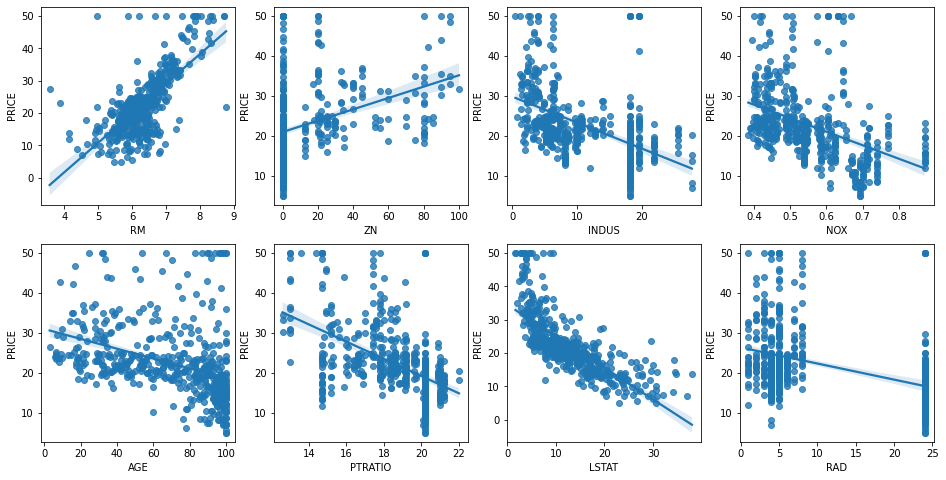

In [2]:
#2개의 행과 4개의 열을 가진 subplots을 이용 axs는 4x2개의 ax를 가짐
fig,axs = plt.subplots(figsize = (16,8),ncols = 4, nrows = 2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i,feature in enumerate(lm_features) :
  row = int(i/4)
  col = i%4
  #with regplot,draw  scatter plot n linear regression line together
  sns.regplot(x = feature,y = 'PRICE',data = bostonDF, ax = axs[row][col])

-> 다른 칼럼보다 RM과 LSTAT의 PRICE영향도가 가장 두드러지게 나타난다. 

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace = False)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state = 156)

# 선형 회귀 OLS로 학습/예측/평가 수행.
#  LinearRegression로 회귀 모델 만들기
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse, rmse))
print('variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE : 4.159
variance score : 0.757


In [4]:
print('intercept :', lr.intercept_)
print('회귀계수수: ', np.round(lr.coef_, 1))

intercept : 40.99559517216477
회귀계수수:  [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


-> coef_ 속성은 회귀 계수 값만 가지고 있으므로 이를 피처별 회귀 계수 값으로 다시 매핑하고, 높은 값 순으로 출력.

sort_values()함수 이용

In [5]:
#회귀 계수를 큰 값 순으로 정렬하기 위해 series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1),index = X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

-> RM이 양의 값으로 회귀 계수가 가장 크며, nox피처의 회귀 계수 -값이 너무 커 보임. 차츰 최적화를 수행하면서 피처 coefficients의 변화도 살펴보자.

In [6]:
#교차 검증으로 MSE와 RMSE를 측정
from sklearn.model_selection import cross_val_score
y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr=LinearRegression()

#cross_val_score() 로 5폴드 세트로 MSE 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores=cross_val_score(lr,X_data,y_target,scoring='neg_mean_squared_error',cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

#cross_val_score(scoring='neg_mean_squared_error')로 반환된 값은 모두 음수
print('5 folds의 개별 Negative MSE scores:',np.round(neg_mse_scores,2))
print('5 folds의 개별 RMSE scores:',np.round(rmse_scores,2))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores: [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE: 5.829
